# 8 Introduction to deep learning for computer vision

计算机视觉是最早也是最大的深度学习成功故事。每天，您都会通过谷歌照片、谷歌图像搜索、YouTube、相机应用程序中的视频过滤器、OCR软件等与深度视觉模型进行交互。这些模型也是自动驾驶、机器人、人工智能辅助医疗诊断、自主零售结账系统甚至自主农业前沿研究的核心。

计算机视觉是2011年至2015年间深度学习最初兴起的问题领域。大约在那个时候，一种名为卷积神经网络的深度学习模型开始在图像分类竞赛中获得非常好的结果，首先是Dan Ciresan赢得了两个竞赛(ICDAR 2011 中文字符识别竞赛 和 IJCNN 2011 德国交通标志识别竞赛)， 更值得注意的是，在2012年秋季，Hinton的团队赢得了备受瞩目的ImageNet大规模视觉识别挑战。在其他计算机视觉任务中，许多更有希望的结果很快就开始冒泡。

有趣的是，这些早期的成功不足以使深度学习成为当时的主流——这花了几年时间。计算机视觉研究社区花了多年时间投资于神经网络以外的方法，它还没有准备好仅仅因为街区里有一个新孩子就放弃它们。2013年和2014年，深度学习仍然面临许多高级计算机视觉研究人员的强烈怀疑。直到2016年，它才最终占据主导地位。我记得2014年2月，我劝过我的一位前教授转向深度学习。“这是下一件大事！”我会说。“好吧，也许这只是一种时尚，”他回答道。到2016年，他的整个实验室都在进行深度学习。时机已经到来，这是无法阻止的想法。

本章介绍了卷积神经网络，也称为convnets，这是一种深度学习模型，现在几乎普遍用于计算机视觉应用。您将学习将convnet应用于图像分类问题——特别是那些涉及小型训练数据集的问题。

## 8.1 Introduction

我们即将深入研究什么是convnet的理论，以及为什么它们在计算机视觉任务方面如此成功。但首先，让我们实际看看一个简单的convnet示例，该示例对MNIST数字进行分类，这是我们在第2章中使用 Dense 连接的网络执行的任务（当时我们的测试精度为97.8%）。

以下列表显示了基本convnet的样子。这是一堆Conv2D和MaxPooling2D层。你将在一分钟内看到他们到底在做什么。我们将使用我们在上一章中介绍的 Functional API 构建模型。

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

2022-04-05 17:03:10.209469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 17:03:10.210024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


重要的是，convnet作为形状的输入张量 `(image_height、image_width、image_channels)`，不包括 batch 维度。在这种情况下，我们将配置convnet以处理大小 `(28，28，1)` 的输入，这是MNIST图像的格式。

让我们展示一下我们convnet的架构。

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0     

您可以看到，每个Conv2D和MaxPooling2D层的输出都是形状的 rank-3 张量（高度、宽度、通道）。随着模型变深，宽度和高度尺寸往往会缩小。通道数量由传递给Conv2D层的第一个参数控制(32、64或128)。

在最后一个Conv2D层之后，我们最终得到一个形状为 (3，3，128) 的输出 —— 一个由128个通道组成3×3的特征图。下一步是将该输出输入一个 Dense分类器，就像您已经熟悉的分类器一样：一堆 Dense 层。这些分类器处理1D向量，而当前输出是rank-3张量。为了弥合差距，在添加 Dense 层之前，我们用 flatten 层将3D输出拉平化为1D。

最后，我们进行10分类，因此我们的最后一层有10个输出和一个softmax激活。

现在，让我们在MNIST数字上训练convnet。我们将重用第2章中MNIST示例中的许多代码。由于我们正在使用softmax输出进行10分类，我们将使用类别交叉熵损失，并且由于我们的标签是整数，我们将使用稀疏版本`sparse_categorical_crossentropy`。

In [4]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() 
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)


2022-04-05 17:14:25.569056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-05 17:14:25.572333: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2022-04-05 17:14:25.879569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 14s 13ms/step - loss: 0.1549 - accuracy: 0.9519
Epoch 2/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0443 - accuracy: 0.9855
Epoch 3/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0307 - accuracy: 0.9903
Epoch 4/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0242 - accuracy: 0.9926
Epoch 5/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0183 - accuracy: 0.9944


In [5]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

 18/313 [>.............................] - ETA: 1s - loss: 0.0370 - accuracy: 0.9913

2022-04-05 17:15:29.246567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 0.0282 - accuracy: 0.9917
Test accuracy: 0.992


第二章的 Dense 连接模型的测试精度为97.8%，而基本convnet的测试精度为99.1%：我们降低了约60%（相对）的错差率。还不错！

但是，与 Dense 连接的模型相比，为什么这个简单的convnet工作得这么好？为了回答这个问题，让我们深入了解 Conv2D 和 MaxPooling2D 层的作用。

### 8.1.1 The convolution operation

Dense 连接层和卷积层之间的根本区别是：Dense 层在其输入特征空间中学习全局模式（例如，对于MNIST数字，涉及所有像素的模式），而卷积层学习局部模式——就图像而言，在输入的小型2D窗口中找到的模式（见图8.1）。在上一个示例中，这些窗口都是3×3。

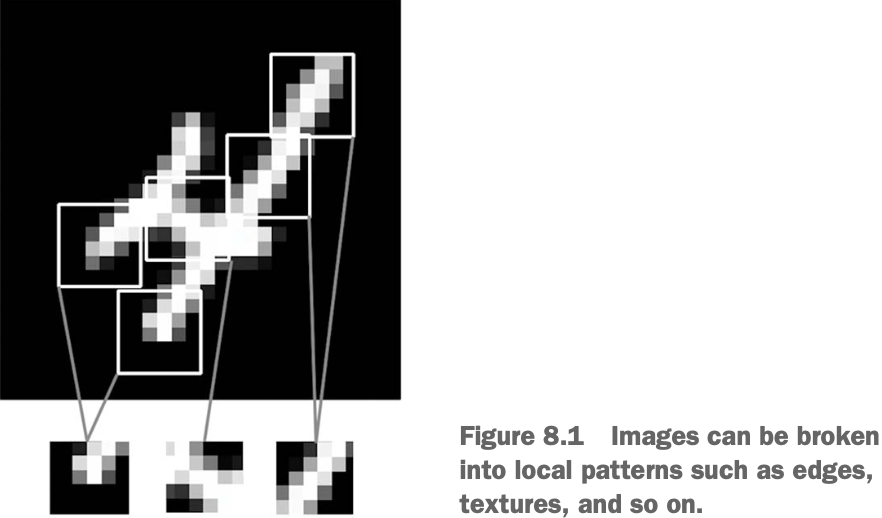

这个关键特征为convnets提供了两个有趣的属性：

- *The patterns they learn are translation-invariant.* 在图片右下角学习特定模式后，convnet可以在任何地方识别它：例如，在左上角。如果一个Dense连接的模型出现在新位置，则必须重新学习模式。这使得convnets在处理图像时具有数据效率（因为视觉世界基本上是平移不变的）：他们需要更少的训练样本来学习具有泛化能力的表示。
- *They can learn spatial hierarchies of patterns.* 第一个卷积层将学习边缘等小局部模式，第二个卷积层将学习由第一层特征组成的更大模式，以此类推（见图8.2）。这允许convnets有效地学习越来越复杂和抽象的视觉概念，因为视觉世界基本上是空间层次的。

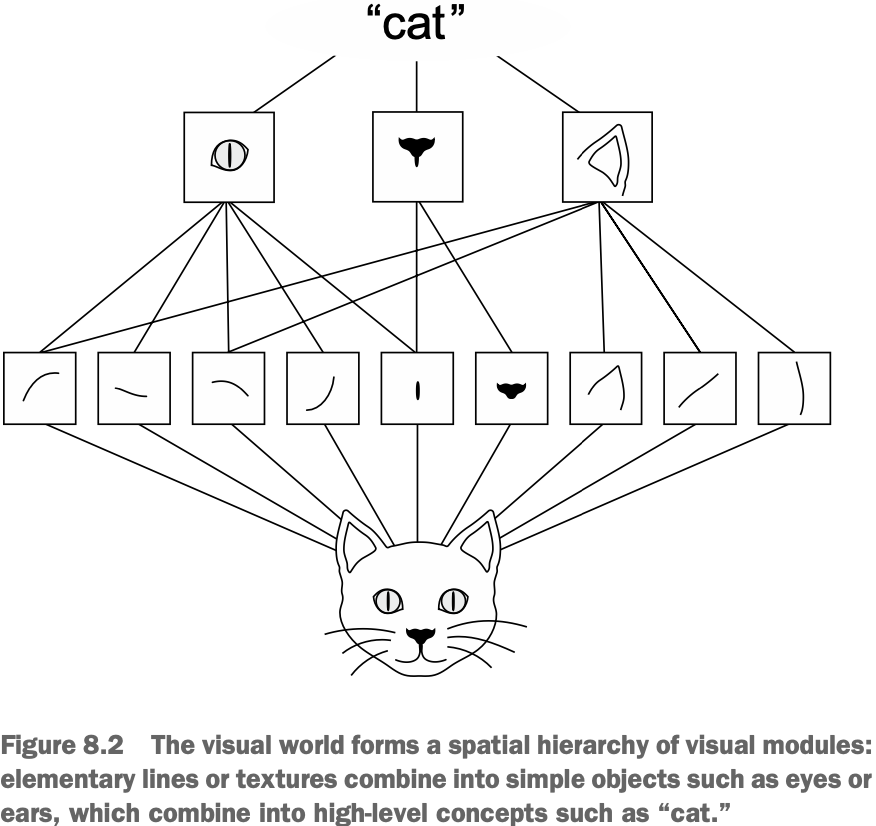

卷积在称为特征映射的 rank-3 张量上运行，具有两个空间轴（高度和宽度）和一个深度轴（也称为通道轴）。对于RGB图像，深度轴的尺寸为3，因为图像有三个颜色：红色、绿色和蓝色。对于黑白图片，如MNIST数字，深度为1（灰色级别）。卷积操作从其输入特征图中提取 patch，并对所有这些 patch 应用相同的转换，生成输出特征映射。此输出特征映射仍然是rank-3张量。 它的深度可以是任意的，因为输出深度是层的参数，该深度轴上的不同通道不再像RGB输入那样代表特定颜色；相反，它们代表 `filter`。 `filter` 编码输入数据的特定方面：例如，在高层上，单个 `filter` 可以编码“输入中存在人脸”的概念。

在MNIST示例中，第一个卷积层输入尺寸为 (28、28、1) 特征图，并输出大小为(26、26、32) 的特征图：它在输入上计算32个 filter。这32个输出通道中的每个都包含一个26×26的 `response grid`，这是 filter 在输入上的响应映射，指示该 filter 模式在输入不同位置的响应（见图8.3）。

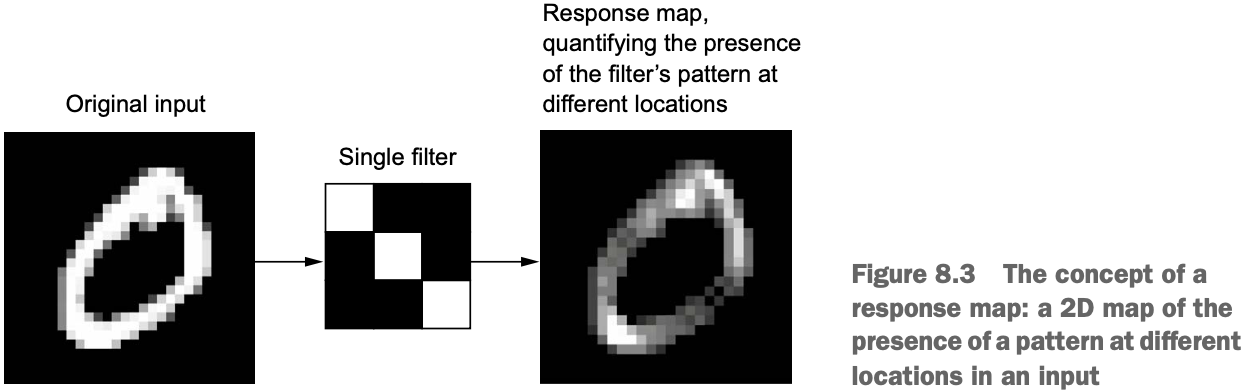

这就是特征映射的含义：深度轴中的每个维度都是特征（或filter），rank-2的张量输出 `[:, :, n]` 是该 filter 对输入响应的二维空间映射。

卷积由两个关键参数定义：

- **Size of the patches extracted from the inputs** —— 这些通常是3×3或5×5。在这个例子中，它们是3×3，这是一个常见的选择。
- **Depth of the output feature map** —— 这是由卷积计算的 filter 数量。该示例以32的深度开始，以64的深度结束。

在Keras Conv2D层中，这些参数是传递给该层的第一个参数：`Conv2D(output_depth，(window_height，window_width))`。

卷积的工作原理是将这些大小为 3×3 或 5×5 的窗口滑动到3D输入特征图上，在每个可能的位置停下来，并提取周围特征的3D patch (shape *(window_height，window_width，input_depth)*)。  然后，每个这样的 3D patch 被转换为形状的1D向量（ `output_depth` ），该向量通过具有学习权重矩阵（称为卷积核）的张量积完成——相同的卷积核在每个 patch 中重复使用。然后，所有这些矢量（每个 patch 一个）在空间上重新组装成形状的3D输出映射（*height, width, output_ depth*）。 输出特征图中的每个空间位置对应于输入特征图中的相同位置（例如，输出的右下角包含有关输入右下角的信息）。例如， `3 x 3` 的窗口， 向量 `output[i, j, :]` 来自于 3D patch `input[i-1:i+1, j-1:j+1, :]`。 完整的过程见图 8.4。

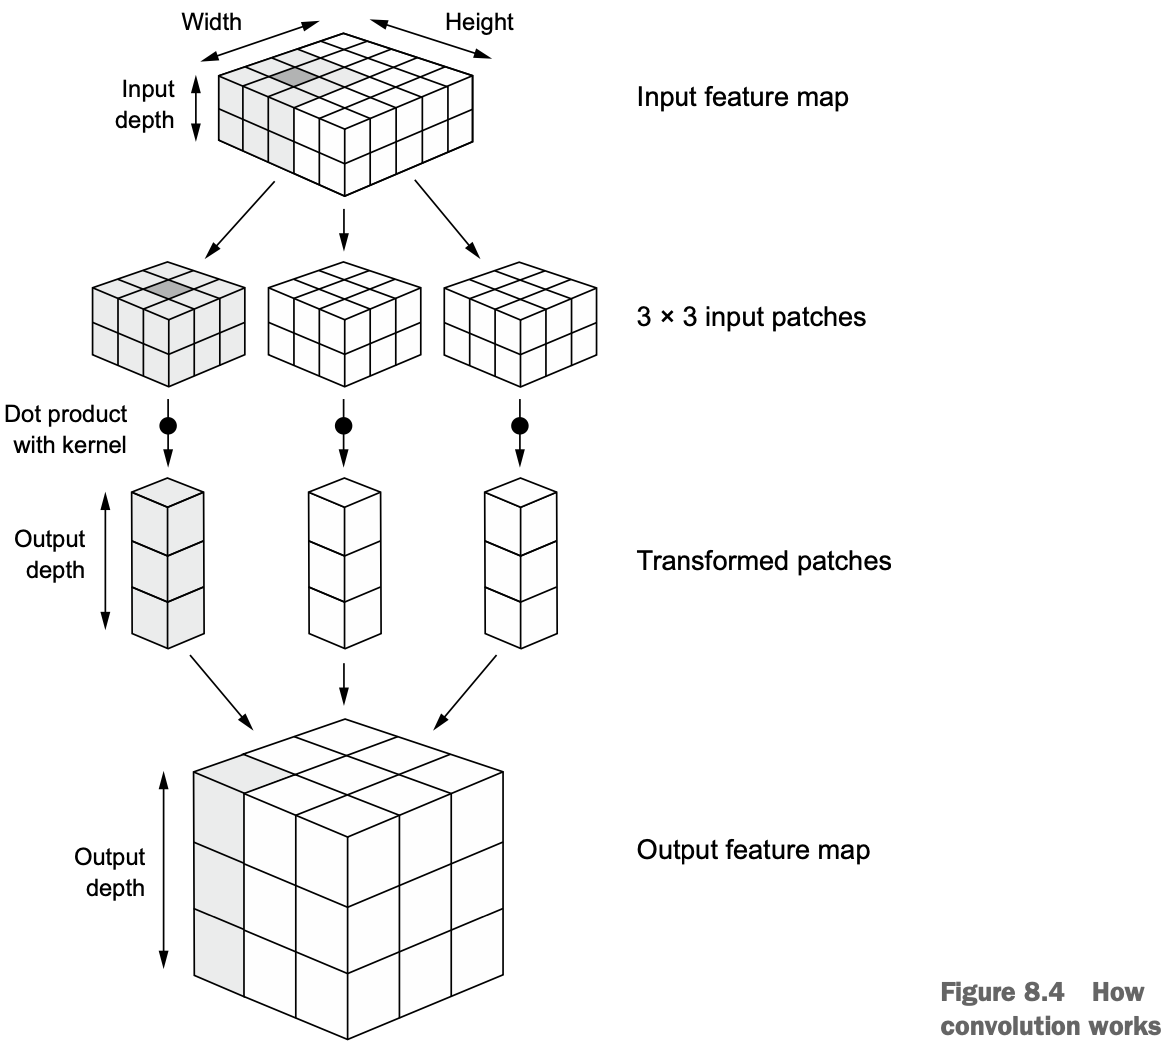

请注意，输出宽度和高度可能与输入宽度和高度不同，原因有二：

- 边界效果，可以通过填充输入特征图来抵消
- `strides` 的使用，我将在随后定义

## 8.2.2 Downloading the data

我们将使用的 狗vs猫 数据集没有与Keras一起打包。2013年底，当convnets不是主流时，Kaggle在计算机视觉竞赛中提供了它。您可以从 [www.kaggle.com/c/dogs-vs-cats/data](www.kaggle.com/c/dogs-vs-cats/data) 下载原始数据集（如果您还没有Kaggle帐户，则需要创建一个Kaggle帐户——别担心，这个过程是无痛的）。您还可以使用 Kaggle API 在 Colab 中下载数据集（请参阅“在Google Colaboratory中下载Kaggle数据集”边栏）

> **Downloading a Kaggle dataset in Google Colaboratory**
> 
> Kaggle提供了易于使用的API，以编程方式下载 Kaggle 托管的数据集。你可以用它来下载 Dogs vs. Cats 的数据集到Colab笔记本。此 API 作为 kaggle 软件包可用，该软件包在Colab上已预安装。下载此数据集就像在Colab单元格中运行以下command一样简单：
>```
>!kaggle competitions download -c dogs-vs-cats
> ```
> 
> 但是，对 API 的访问仅限于 Kaggle 用户，因此为了运行预割让命令，您首先需要对自己进行身份验证。kaggle软件包将在位于 `~/.kaggle/kaggle.json` 的JSON文件中查找您的登录凭据。让我们创建这个文件。
>
> 首先，您需要创建一个 Kaggle API 密钥并将其下载到本地计算机。只需在网页浏览器中导航到 Kaggle 网站，登录并转到我的帐户页面。在您的帐户设置中，您将找到一个 API 部分。单击创建新 API token 按钮将生成一个kaggle.json 密钥文件，并将其下载到您的机器上。
>
> 其次，转到您的Colab notebook，并通过在 notebook 单元格中运行以下代码将API的关键JSON文件上传到您的Colab会话：
> 
> ```python
> from google.colab import files 
> files.upload()
> ```
> 
> 当您运行此单元格时，您将看到一个选择文件按钮。单击它，然后选择您刚刚下载的kaggle.json文件。这会将文件上传到本地Colab runtime。
> 
> 最后， 创建一个 `~/.kaggle` 文件夹 (`mkdir~/.kaggle`), 并将密钥文件复制到它 (`cpkaggle.json~/.kaggle/`)。 作为安全最佳实践，您还应该确保文件只能由当前用户自己读取（ `chmod600`）：
> 
> ```
> !mkdir ~/.kaggle
> !cp kaggle.json ~/.kaggle/
> !chmod 600 ~/.kaggle/kaggle.json
> ```
> 
> 您现在可以下载我们即将使用的数据：
>
> ```
> !kaggle competitions download -c dogs-vs-cats
> ```
>
> 第一次尝试下载数据时，您可能会收到“403禁止”错误。这是因为在下载数据集之前，您需要接受与数据集相关的条款——您必须转到 [www.kaggle.com/c/dogs-vs-cats/rules](www.kaggle.com/c/dogs-vs-cats/rules) （登录您的Kaggle帐户时），然后单击“我理解和接受”按钮。你只需要这样做一次。
> 
> 最后，训练数据是一个名为train.zip的压缩文件。确保您默默(`-qq`)解压缩（`unzip`）：
> 
> ```
> !unzip -qq train.zip
> ```

### 8.2.4 Data preprocessing

> **Understanding TensorFlow `Dataset` objects**
> 
> TensorFlow 提供了 `tf.data` API，为机器学习模型创建高效的输入管道。它的核心类是 `tf.data.Dataset`。
>
> `Dataset` 对象是一个迭代器：您可以在 `for` 循环中使用它。它通常会返回成批的输入数据和标签。您可以将 `Dataset` 对象直接传递给 Keras 模型的 `fit()` 方法。
> 
> `Dataset` 类处理许多关键特性，否则实现自己会很麻烦——特别是异步数据预获取（在模型处理上一批数据时预处理下一批数据，这使执行不间断）。
> 
> `Dataset` 类还公开了一个用于修改数据集的 Functional-style API。这里有一个快速示例：让我们从随机数字的 NumPy 数组创建一个数据集实例。我们将考虑1000个样本，其中每个样本都是大小为16的矢量：
> 
> ```python
> import numpy as np
> import tensorflow as tf
> random_numbers = np.random.normal(size=(1000, 16))
> dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
> 
> 首先，我们的数据集只产生单个样本：

> ```python
> for i, element in enumerate(dataset):
>     print(element.shape)
>     if i >= 2:
>         break
(16,)
(16,)
(16,)
> ```
> 
> 我们可以使用 `.batch()` 方法来批处理数据：
> 
> ```python
> batched_dataset = dataset.batch(32)
> for i, element in enumerate(batched_dataset):\
>     print(element.shape)
>     if i >= 2:
>         break
(32, 16)
(32, 16)
(32, 16)
> ```
> 
> 更广泛地说，我们可以访问一系列有用的数据集方法，例如
> 
> - `.shuffle(buffer_size)` —— 在缓冲区中洗牌元素
> - `.prefetch(buffer_size)` —— 在GPU内存中预取元素缓冲区， 实现更好的设备利用率。
> - `- .map(callable)` —— 对数据集每个元素应用任意 transformation（可调用的函数，期望将数据集生成的单个元素作为输入）。
> 
> 特别是 `.map()` 方法，您将经常使用这种方法。这里有一个例子。我们将使用它来 reshape 数据集中的元素，从形状（16）到形状（4，4）：
>
> ```python
> reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
> for i, element in enumerate(reshaped_dataset):
>     print(element.shape)
>     if i >= 2:
>         break
> (4, 4)
(4, 4)
(4, 4)
> 
> 您即将在本章中看到更多 `map()` 操作。
